In [1]:
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Statistical analysis
from scipy import stats
from scipy.stats import zscore

/Users/vaishnavverma/.matplotlib is not a writable directory
Matplotlib created a temporary cache directory at /var/folders/gp/0qsbr0x11d315dt15fl17c940000gn/T/matplotlib-c8sqvln2 because there was an issue with the default path (/Users/vaishnavverma/.matplotlib); it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
Matplotlib is building the font cache; this may take a moment.


In [2]:
# Load the dataset
df_raw = pd.read_csv('../data/processed/movies_clean.csv')

# Create a copy for preprocessing
df = df_raw.copy()

print(f"Dataset loaded successfully!")
print(f"Shape: {df.shape}")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

Dataset loaded successfully!
Shape: (338005, 13)
Memory usage: 119.62 MB


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 338005 entries, 0 to 338004
Data columns (total 13 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   tconst          338005 non-null  object 
 1   primaryTitle    338004 non-null  object 
 2   originalTitle   338004 non-null  object 
 3   titleType       338005 non-null  object 
 4   isAdult         338005 non-null  int64  
 5   startYear       337972 non-null  float64
 6   runtimeMinutes  304069 non-null  float64
 7   genres          326688 non-null  object 
 8   averageRating   338005 non-null  float64
 9   numVotes        338005 non-null  int64  
 10  decade          338005 non-null  int64  
 11  revenue         286279 non-null  float64
 12  budget          286279 non-null  float64
dtypes: float64(5), int64(3), object(5)
memory usage: 33.5+ MB


In [4]:
# Check uniqueness of tconst
duplicates = df['tconst'].duplicated().sum()
print(f"Number of duplicate tconst values: {duplicates}")
print(f"Total unique tconst values: {df['tconst'].nunique()}")
print(f"Total rows: {len(df)}")

Number of duplicate tconst values: 0
Total unique tconst values: 338005
Total rows: 338005


In [5]:
# Analyze missing values
print("Missing Values Summary:")
print("=" * 60)
missing_summary = pd.DataFrame({
    'Column': df.columns,
    'Missing_Count': df.isnull().sum(),
    'Missing_Percentage': (df.isnull().sum() / len(df) * 100).round(2)
})
missing_summary = missing_summary[missing_summary['Missing_Count'] > 0].sort_values('Missing_Count', ascending=False)
print(missing_summary.to_string(index=False))
print("\n")

# Handle missing values
# 1. Drop rows with missing primaryTitle or originalTitle (only 1 row)
df = df.dropna(subset=['primaryTitle', 'originalTitle'])

# 2. Fill missing startYear with median or drop (34 rows - minimal impact)
df = df.dropna(subset=['startYear'])

# 3. Keep missing runtimeMinutes as is (will handle in analysis if needed)
# 4. Keep missing genres as is (will handle separately if needed)

print(f"After handling missing values:")
print(f"Shape: {df.shape}")
print(f"Remaining missing values:\n{df.isnull().sum()}")

Missing Values Summary:
        Column  Missing_Count  Missing_Percentage
       revenue          51726               15.30
        budget          51726               15.30
runtimeMinutes          33936               10.04
        genres          11317                3.35
     startYear             33                0.01
  primaryTitle              1                0.00
 originalTitle              1                0.00


After handling missing values:
Shape: (337971, 13)
Remaining missing values:
tconst                0
primaryTitle          0
originalTitle         0
titleType             0
isAdult               0
startYear             0
runtimeMinutes    33922
genres            11317
averageRating         0
numVotes              0
decade                0
revenue           51708
budget            51708
dtype: int64


In [6]:
# Handle missing genres
df['genres'] = df['genres'].fillna('Unknown')

print(f"Missing genres filled with 'Unknown'")
print(f"Remaining missing values in genres: {df['genres'].isnull().sum()}")
print(f"\nGenres value counts (top 10):")
print(df['genres'].value_counts().head(10))

Missing genres filled with 'Unknown'
Remaining missing values in genres: 0

Genres value counts (top 10):
genres
Drama                   57123
Documentary             37270
Comedy                  26844
Unknown                 11317
Comedy,Drama            10687
Drama,Romance           10189
Horror                   8378
Comedy,Romance           5924
Thriller                 5379
Comedy,Drama,Romance     5072
Name: count, dtype: int64


In [7]:
# Handle runtimeMinutes by imputing median by titleType
df['runtimeMinutes'] = df.groupby('titleType')['runtimeMinutes'].transform(lambda x: x.fillna(x.median()))

print(f"Missing runtimeMinutes after imputation: {df['runtimeMinutes'].isnull().sum()}")
print(f"\nRuntimeMinutes statistics by titleType:")
print(df.groupby('titleType')['runtimeMinutes'].describe())

Missing runtimeMinutes after imputation: 0

RuntimeMinutes statistics by titleType:
              count       mean         std  min   25%   50%    75%      max
titleType                                                                  
movie      337971.0  94.235325  167.636475  1.0  82.0  91.0  101.0  59460.0


In [19]:
# Handle Budget and Revenue
print("=== BUDGET & REVENUE PREPROCESSING ===\n")

# Check initial stats
print("Initial Statistics:")
print(f"Budget - Non-null: {df['budget'].notna().sum()}, Zeros: {(df['budget'] == 0).sum()}")
print(f"Revenue - Non-null: {df['revenue'].notna().sum()}, Zeros: {(df['revenue'] == 0).sum()}")

# Replace 0 with NaN (0 means "no data" not "$0")
df['budget'] = df['budget'].replace(0, np.nan)
df['revenue'] = df['revenue'].replace(0, np.nan)

# Clip outliers at 99.5 percentile (for non-null values)
budget_cap = df['budget'].quantile(0.995)
revenue_cap = df['revenue'].quantile(0.995)
df['budget'] = df['budget'].clip(upper=budget_cap)
df['revenue'] = df['revenue'].clip(upper=revenue_cap)

# Create log-transformed features
df['logBudget'] = np.log1p(df['budget'])
df['logRevenue'] = np.log1p(df['revenue'])

# Create derived features
df['profit'] = df['revenue'] - df['budget']
df['roi'] = (df['revenue'] - df['budget']) / df['budget']  # Return on Investment

print(f"\nAfter preprocessing:")
print(f"Movies with valid budget: {df['budget'].notna().sum()}")
print(f"Movies with valid revenue: {df['revenue'].notna().sum()}")
print(f"\nBudget range: ${df['budget'].min():,.0f} - ${df['budget'].max():,.0f}")
print(f"Revenue range: ${df['revenue'].min():,.0f} - ${df['revenue'].max():,.0f}")
print(f"\nNew features created: logBudget, logRevenue, profit, roi")

=== BUDGET & REVENUE PREPROCESSING ===

Initial Statistics:
Budget - Non-null: 26752, Zeros: 0
Revenue - Non-null: 20618, Zeros: 0

After preprocessing:
Movies with valid budget: 26752
Movies with valid revenue: 20618

Budget range: $1 - $185,000,000
Revenue range: $1 - $816,755,285

New features created: logBudget, logRevenue, profit, roi


In [12]:
# Create comprehensive data quality report
def data_quality_report(dataframe):
    """
    Generate a comprehensive data quality report
    """
    quality_df = pd.DataFrame({
        'Column': dataframe.columns,
        'Data_Type': dataframe.dtypes.values,
        'Non_Null_Count': dataframe.count().values,
        'Null_Count': dataframe.isnull().sum().values,
        'Null_Percentage': (dataframe.isnull().sum() / len(dataframe) * 100).values,
        'Unique_Values': [dataframe[col].nunique() for col in dataframe.columns],
        'Unique_Percentage': [(dataframe[col].nunique() / len(dataframe) * 100) for col in dataframe.columns]
    })
    
    quality_df = quality_df.sort_values('Null_Percentage', ascending=False).reset_index(drop=True)
    return quality_df

quality_report = data_quality_report(df)
print("\n=== DATA QUALITY REPORT ===")
print(quality_report)


=== DATA QUALITY REPORT ===
            Column Data_Type  Non_Null_Count  Null_Count  Null_Percentage  \
0              roi   float64           12291      325680        96.363297   
1           profit   float64           12291      325680        96.363297   
2       logRevenue   float64           20618      317353        93.899477   
3          revenue   float64           20618      317353        93.899477   
4        logBudget   float64           26752      311219        92.084528   
5           budget   float64           26752      311219        92.084528   
6         numVotes     int64          337971           0         0.000000   
7           decade     int64          337971           0         0.000000   
8           tconst    object          337971           0         0.000000   
9     primaryTitle    object          337971           0         0.000000   
10          genres    object          337971           0         0.000000   
11  runtimeMinutes   float64          337971   

In [13]:
df.describe()

,isAdult,startYear,runtimeMinutes,averageRating,numVotes,decade,revenue,budget,logBudget,logRevenue,profit,roi
count,337971.000000,337971.000000,337971.000000,337971.000000,3.379710e+05,337971.000000,2.061800e+04,2.675200e+04,26752.000000,20618.000000,1.229100e+04,1.229100e+04
mean,0.013904,1997.032461,94.235325,6.124226,3.657491e+03,1992.617562,3.680284e+07,1.110754e+07,13.462324,14.663097,3.544369e+07,8.272436e+02
std,0.117091,26.149844,167.636475,1.375391,3.726906e+04,26.398205,1.005813e+08,2.559345e+07,3.492938,3.229377,1.013955e+08,4.484108e+04
min,0.000000,1894.000000,1.000000,1.000000,5.000000e+00,1890.000000,1.000000e+00,1.000000e+00,0.693147,0.693147,-1.845460e+08,-9.999999e-01
25%,0.000000,1981.000000,82.000000,5.300000,2.000000e+01,1980.000000,4.002480e+05,1.000000e+05,11.512935,12.899842,-1.997219e+06,-4.599949e-01
50%,0.000000,2007.000000,91.000000,6.200000,6.300000e+01,2000.000000,3.652139e+06,1.487705e+06,14.212746,15.110824,1.665000e+06,6.363636e-01
75%,0.000000,2017.000000,101.000000,7.000000,3.200000e+02,2010.000000,2.242330e+07,1.000000e+07,16.118096,16.925611,2.613958e+07,2.636654e+00
max,1.000000,2025.000000,59460.000000,10.000000,3.122268e+06,2020.000000,8.169517e+08,1.850000e+08,19.035866,20.521091,7.872517e+08,3.000002e+06


=== OUTLIER ANALYSIS ===

Ratings Distribution:
count    337971.000000
mean          6.124226
std           1.375391
min           1.000000
25%           5.300000
50%           6.200000
75%           7.000000
max          10.000000
Name: averageRating, dtype: float64
Valid rating range should be: 0-10
Ratings outside valid range: 0

Votes Distribution:
count    337971.000000
mean       2464.437131
std       14409.801159
min           5.000000
25%          20.000000
50%          63.000000
75%         320.000000
max      158437.850000
Name: numVotes, dtype: float64

99.5th percentile for numVotes: 158432.87750000026


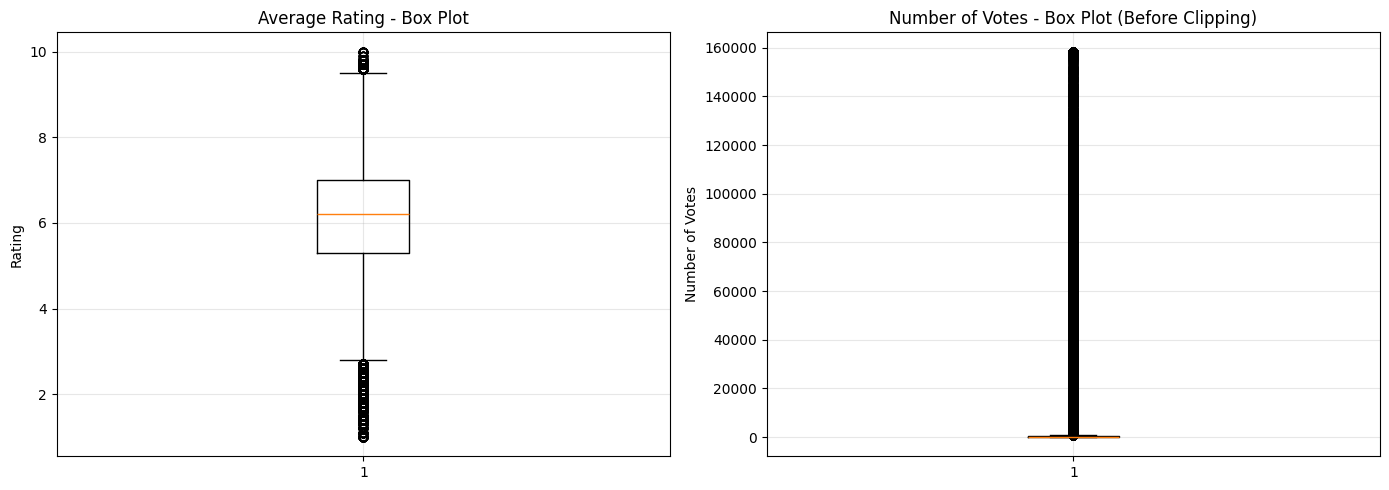


=== AFTER HANDLING OUTLIERS ===

Dataset shape: (337971, 38)

Ratings statistics:
count    337971.000000
mean          6.124226
std           1.375391
min           1.000000
25%           5.300000
50%           6.200000
75%           7.000000
max          10.000000
Name: averageRating, dtype: float64

Votes statistics:
count    337971.000000
mean       2464.412266
std       14409.532022
min           5.000000
25%          20.000000
50%          63.000000
75%         320.000000
max      158432.877500
Name: numVotes, dtype: float64


In [20]:
# Detect and handle outliers in ratings and votes

# 1. Analyze outliers before handling
print("=== OUTLIER ANALYSIS ===\n")

# Ratings analysis
print("Ratings Distribution:")
print(df['averageRating'].describe())
print(f"Valid rating range should be: 0-10")
print(f"Ratings outside valid range: {((df['averageRating'] < 0) | (df['averageRating'] > 10)).sum()}")

# Votes analysis
print("\nVotes Distribution:")
print(df['numVotes'].describe())
print(f"\n99.5th percentile for numVotes: {df['numVotes'].quantile(0.995)}")

# Visualize outliers
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Box plot for ratings
axes[0].boxplot(df['averageRating'])
axes[0].set_title('Average Rating - Box Plot')
axes[0].set_ylabel('Rating')
axes[0].grid(True, alpha=0.3)

# Box plot for votes (before clipping)
axes[1].boxplot(df['numVotes'])
axes[1].set_title('Number of Votes - Box Plot (Before Clipping)')
axes[1].set_ylabel('Number of Votes')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 2. Handle outliers
# Clip votes at 99.5 percentile
df['numVotes'] = df['numVotes'].clip(upper=df['numVotes'].quantile(0.995))

# Keep only valid ratings (0-10 range)
df = df[(df['averageRating'] >= 0) & (df['averageRating'] <= 10)]

print("\n=== AFTER HANDLING OUTLIERS ===\n")
print(f"Dataset shape: {df.shape}")
print(f"\nRatings statistics:")
print(df['averageRating'].describe())
print(f"\nVotes statistics:")
print(df['numVotes'].describe())

In [21]:
# Feature Engineering
print("=== FEATURE ENGINEERING ===\n")

# 1. Primary Genre (first genre in the list)
df['primaryGenre'] = df['genres'].apply(lambda x: x.split(',')[0] if ',' in x else x)
print(f"Primary Genre created. Unique values: {df['primaryGenre'].nunique()}")

# 2. Number of Genres
df['numGenres'] = df['genres'].apply(lambda x: len(x.split(',')) if x != 'Unknown' else 0)
print(f"Number of Genres created. Range: {df['numGenres'].min()} to {df['numGenres'].max()}")

# 3. Log-transformed votes (to handle skewness)
df['logVotes'] = np.log1p(df['numVotes'])
print(f"Log Votes created. Range: {df['logVotes'].min():.2f} to {df['logVotes'].max():.2f}")

# 4. Bayesian Average Rating (weighted rating considering number of votes)
m = df['numVotes'].quantile(0.75)  # minimum votes required
C = df['averageRating'].mean()  # mean rating across all movies
df['bayes_rating'] = (df['numVotes'] / (df['numVotes'] + m) * df['averageRating']) + (m / (df['numVotes'] + m) * C)
print(f"Bayesian Rating created. Range: {df['bayes_rating'].min():.2f} to {df['bayes_rating'].max():.2f}")

# 5. Runtime bins (categorize movies by length)
df['runtime_bin'] = pd.cut(df['runtimeMinutes'], 
                            bins=[0, 60, 90, 120, 150, float('inf')],
                            labels=['Short (<60)', 'Medium (60-90)', 'Standard (90-120)', 'Long (120-150)', 'Very Long (>150)'])
print(f"Runtime bins created. Categories: {df['runtime_bin'].unique().tolist()}")

print("\n=== FEATURE ENGINEERING SUMMARY ===")
print(f"Total features: {df.shape[1]}")
print(f"\nNew features added:")
print(f"  - primaryGenre (categorical)")
print(f"  - numGenres (numeric)")
print(f"  - logVotes (numeric)")
print(f"  - bayes_rating (numeric)")
print(f"  - runtime_bin (categorical)")

print(f"\nDataset shape: {df.shape}")
print(f"\nSample of new features:")
print(df[['primaryTitle', 'primaryGenre', 'numGenres', 'logVotes', 'bayes_rating', 'runtime_bin']].head(10))

=== FEATURE ENGINEERING ===

Primary Genre created. Unique values: 28
Number of Genres created. Range: 0 to 3
Log Votes created. Range: 1.79 to 11.97
Bayesian Rating created. Range: 1.02 to 9.29
Runtime bins created. Categories: ['Short (<60)', 'Standard (90-120)', 'Medium (60-90)', 'Long (120-150)', 'Very Long (>150)']

=== FEATURE ENGINEERING SUMMARY ===
Total features: 38

New features added:
  - primaryGenre (categorical)
  - numGenres (numeric)
  - logVotes (numeric)
  - bayes_rating (numeric)
  - runtime_bin (categorical)

Dataset shape: (337971, 38)

Sample of new features:
                     primaryTitle primaryGenre  numGenres  logVotes  \
0                      Miss Jerry      Romance          1  5.451038   
1   The Corbett-Fitzsimmons Fight  Documentary          3  6.359574   
2           Soldiers of the Cross    Biography          2  4.174387   
3                        Bohemios      Unknown          0  3.295837   
4     The Story of the Kelly Gang       Action          3

In [22]:
# Categorical Encoding
print("=== CATEGORICAL ENCODING ===\n")

# 1. Encode titleType (should be only 'movie' based on quality report)
print(f"titleType unique values: {df['titleType'].unique()}")

# 2. Encode primaryGenre - limit to top genres
top_n_genres = 15
top_genres = df['primaryGenre'].value_counts().head(top_n_genres).index.tolist()
df['primaryGenre_encoded'] = df['primaryGenre'].apply(lambda x: x if x in top_genres else 'Other')

print(f"\nPrimary Genre Encoding:")
print(f"  - Original unique genres: {df['primaryGenre'].nunique()}")
print(f"  - Top {top_n_genres} genres kept: {len(top_genres)}")
print(f"  - After encoding (including 'Other'): {df['primaryGenre_encoded'].nunique()}")
print(f"\nTop genres distribution:")
print(df['primaryGenre_encoded'].value_counts())

# 3. One-hot encode primaryGenre_encoded
df_encoded = pd.get_dummies(df, columns=['primaryGenre_encoded'], prefix='genre', drop_first=False)

print(f"\n=== AFTER ONE-HOT ENCODING ===")
print(f"Total columns: {df_encoded.shape[1]}")
print(f"New genre columns added: {df_encoded.shape[1] - df.shape[1]}")

# Show the genre columns created
genre_columns = [col for col in df_encoded.columns if col.startswith('genre_')]
print(f"\nGenre columns created ({len(genre_columns)}):")
print(genre_columns)

print(f"\nFinal dataset shape: {df_encoded.shape}")
print(f"\nSample of encoded features:")
print(df_encoded[['primaryTitle', 'primaryGenre'] + genre_columns[:5]].head())

# Update df with encoded version
df = df_encoded

=== CATEGORICAL ENCODING ===

titleType unique values: ['movie']

Primary Genre Encoding:
  - Original unique genres: 28
  - Top 15 genres kept: 15
  - After encoding (including 'Other'): 16

Top genres distribution:
primaryGenre_encoded
Drama          95507
Comedy         69173
Documentary    46540
Action         34508
Crime          15933
Horror         14234
Adventure      13312
Unknown        11317
Biography       9754
Other           6714
Thriller        5406
Adult           4644
Romance         3540
Animation       3177
Family          2387
Fantasy         1825
Name: count, dtype: int64

=== AFTER ONE-HOT ENCODING ===
Total columns: 54
New genre columns added: 15

Genre columns created (32):
['genre_Action', 'genre_Adult', 'genre_Adventure', 'genre_Animation', 'genre_Biography', 'genre_Comedy', 'genre_Crime', 'genre_Documentary', 'genre_Drama', 'genre_Family', 'genre_Fantasy', 'genre_Horror', 'genre_Other', 'genre_Romance', 'genre_Thriller', 'genre_Unknown', 'genre_Action', 'genr

=== CORRELATION ANALYSIS ===



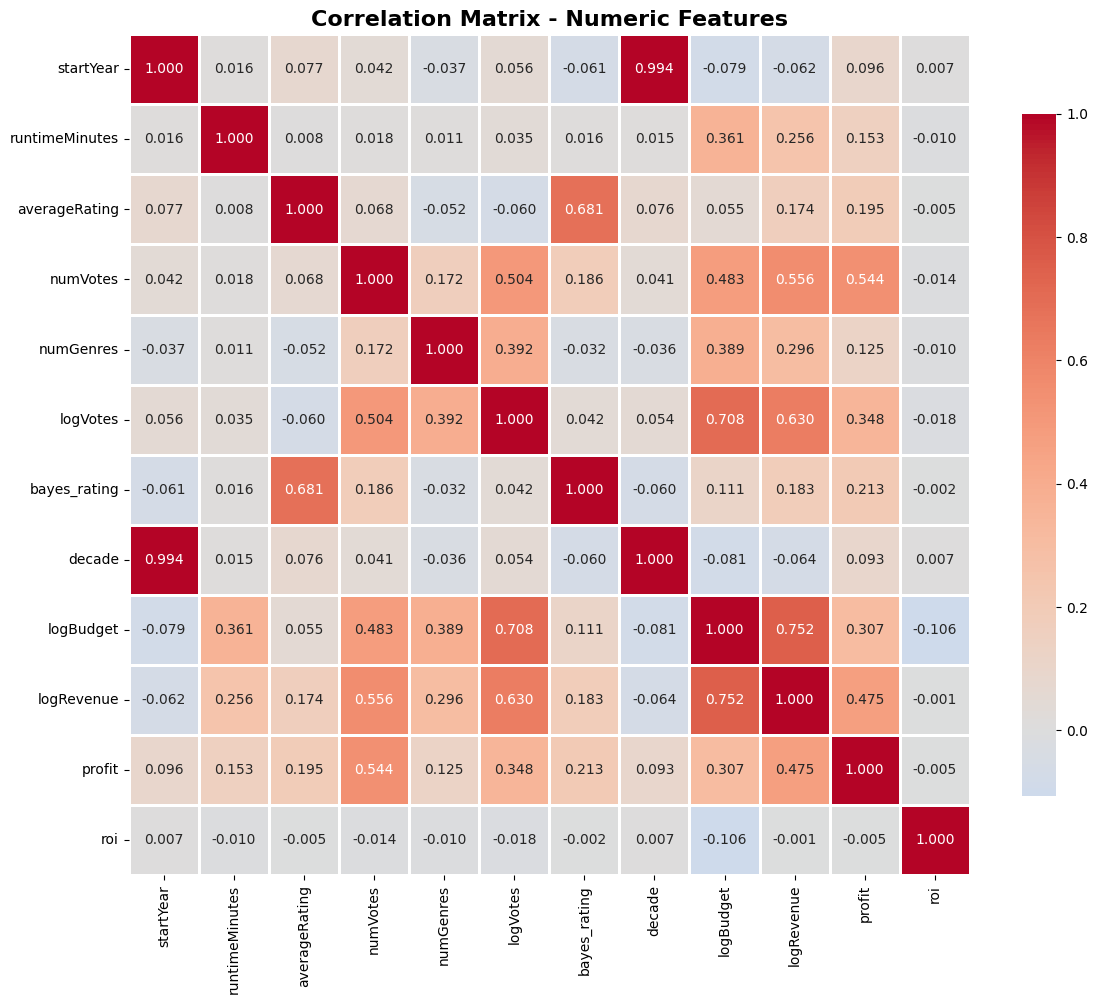


=== HIGHLY CORRELATED FEATURES (|r| > 0.7) ===

Feature 1  Feature 2  Correlation
startYear     decade     0.994209
logBudget logRevenue     0.752396
 logVotes  logBudget     0.707892

=== CORRELATION WITH TARGET (averageRating) ===

averageRating     1.000000
bayes_rating      0.681288
profit            0.194874
logRevenue        0.173501
startYear         0.076809
decade            0.075964
numVotes          0.068430
logBudget         0.054782
runtimeMinutes    0.007656
roi              -0.004505
numGenres        -0.051880
logVotes         -0.059734
Name: averageRating, dtype: float64

=== FEATURE SELECTION RECOMMENDATIONS ===

Based on correlation analysis:
1. High multicollinearity detected between:
   - startYear & decade: r = 0.994
   - logVotes & logBudget: r = 0.708
   - logBudget & logRevenue: r = 0.752

2. Consider keeping one feature from each highly correlated pair
3. Features with strongest correlation to averageRating:
   - bayes_rating: r = 0.681
   - profit: r = 0.195


In [23]:
# Correlation Analysis
print("=== CORRELATION ANALYSIS ===\n")

# Select numeric features for correlation analysis (including budget/revenue)
numeric_features = ['startYear', 'runtimeMinutes', 'averageRating', 'numVotes', 
                   'numGenres', 'logVotes', 'bayes_rating', 'decade',
                   'logBudget', 'logRevenue', 'profit', 'roi']

# Filter to only existing columns with sufficient data
numeric_features = [col for col in numeric_features if col in df.columns]

# Calculate correlation matrix
correlation_matrix = df[numeric_features].corr()

# Visualize correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.3f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix - Numeric Features', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Identify highly correlated pairs (|correlation| > 0.7, excluding diagonal)
print("\n=== HIGHLY CORRELATED FEATURES (|r| > 0.7) ===\n")
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > 0.7:
            high_corr_pairs.append({
                'Feature 1': correlation_matrix.columns[i],
                'Feature 2': correlation_matrix.columns[j],
                'Correlation': correlation_matrix.iloc[i, j]
            })

if high_corr_pairs:
    high_corr_df = pd.DataFrame(high_corr_pairs).sort_values('Correlation', 
                                                              key=abs, 
                                                              ascending=False)
    print(high_corr_df.to_string(index=False))
else:
    print("No feature pairs with |correlation| > 0.7 found.")

# Correlation with target variable (averageRating)
print("\n=== CORRELATION WITH TARGET (averageRating) ===\n")
target_corr = correlation_matrix['averageRating'].sort_values(ascending=False)
print(target_corr)

# Feature selection recommendations
print("\n=== FEATURE SELECTION RECOMMENDATIONS ===\n")
print("Based on correlation analysis:")
print("1. High multicollinearity detected between:")
for pair in high_corr_pairs:
    print(f"   - {pair['Feature 1']} & {pair['Feature 2']}: r = {pair['Correlation']:.3f}")
print("\n2. Consider keeping one feature from each highly correlated pair")
print("3. Features with strongest correlation to averageRating:")
top_features = target_corr.drop('averageRating').head(3)
for feature, corr_value in top_features.items():
    print(f"   - {feature}: r = {corr_value:.3f}")

In [24]:
# Save the processed dataset
print("=== SAVING PROCESSED DATASET ===\n")

# Define output path
output_path = "../data/processed/imdb_movies_processed.csv"
# Save to CSV
df.to_csv(output_path, index=False)

print(f"✓ Processed dataset saved successfully!")
print(f"  Path: {output_path}")
print(f"  Shape: {df.shape}")
print(f"  File size: {pd.read_csv(output_path).memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Summary of preprocessing steps
print("\n=== PREPROCESSING SUMMARY ===")
print(f"Original dataset shape: {df_raw.shape}")
print(f"Final dataset shape: {df.shape}")
print(f"Rows removed: {df_raw.shape[0] - df.shape[0]}")
print(f"Features added: {df.shape[1] - df_raw.shape[1]}")
print(f"\nNew features created:")
print(f"  - primaryGenre, numGenres, logVotes")
print(f"  - bayes_rating, runtime_bin")
print(f"  - logBudget, logRevenue, profit, roi")
print(f"  - 16 one-hot encoded genre columns")
print(f"\nData quality improvements:")
print(f"  - Missing values handled")
print(f"  - Budget/Revenue zeros treated as missing")
print(f"  - Outliers clipped/removed")
print(f"  - Categorical features encoded")

=== SAVING PROCESSED DATASET ===

✓ Processed dataset saved successfully!
  Path: ../data/processed/imdb_movies_processed.csv
  Shape: (337971, 54)
✓ Processed dataset saved successfully!
  Path: ../data/processed/imdb_movies_processed.csv
  Shape: (337971, 54)
  File size: 186.88 MB

=== PREPROCESSING SUMMARY ===
Original dataset shape: (338005, 13)
Final dataset shape: (337971, 54)
Rows removed: 34
Features added: 41

New features created:
  - primaryGenre, numGenres, logVotes
  - bayes_rating, runtime_bin
  - logBudget, logRevenue, profit, roi
  - 16 one-hot encoded genre columns

Data quality improvements:
  - Missing values handled
  - Budget/Revenue zeros treated as missing
  - Outliers clipped/removed
  - Categorical features encoded
  File size: 186.88 MB

=== PREPROCESSING SUMMARY ===
Original dataset shape: (338005, 13)
Final dataset shape: (337971, 54)
Rows removed: 34
Features added: 41

New features created:
  - primaryGenre, numGenres, logVotes
  - bayes_rating, runtime_b